<a href="https://colab.research.google.com/github/annacheng/annacheng.github.io/blob/master/PS_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
from google.colab import files

file_name = 'PSdata.xlsx'

df = pd.read_excel(file_name, sheet_name=1, header=1)
df['Month'] = pd.to_datetime(df['Month'])
df = df.dropna(axis=1, how='all')

In [ ]:
df


,Game,Month,Subscriber Tier,Game Sales (Units),Game Sales (Revenue),Av. MTX Spend,Player Volumes
0,Game A,2022-06-01,Essential,68266.666667,254567.383040,0.000000,177493.333333
1,Game A,2022-07-01,Essential,55920.800000,205093.090563,0.000000,119512.177778
2,Game A,2022-08-01,Essential,59070.000000,214427.415599,0.000000,113536.568889
3,Game A,2022-09-01,Essential,57610.800000,212966.406147,0.000000,102182.912000
4,Game A,2022-10-01,Essential,60718.133333,225926.969052,0.000000,132837.785600
...,...,...,...,...,...,...,...
243,Game B,2024-08-01,Premium,9399.040000,54985.296741,0.966117,44837.912043
244,Game B,2024-09-01,Premium,6128.640000,36488.397693,1.156790,42596.016440
245,Game B,2024-10-01,Premium,6479.680000,37333.837608,0.996770,45151.777427
246,Game B,2024-11-01,Premium,6081.386667,35633.610112,0.997171,29348.655327


In [ ]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

def train_and_predict_xgb_limited(df_target, tier_label):
    # Uses global variables for date cutoffs:
    # pre_cutoff, prediction_start, prediction_end

    # Train on pre-intervention data
    X_train = df_target.loc[:pre_cutoff][['x1', 'x2']]
    y_train = df_target.loc[:pre_cutoff]['target']

    # Predict for post-intervention window
    X_pred = df_target.loc[prediction_start:prediction_end][['x1', 'x2']]
    y_actual = df_target.loc[prediction_start:prediction_end]['target']

    # Train model
    model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict and return result DataFrame
    y_pred = model.predict(X_pred)
    result = pd.DataFrame({
        'Month': y_actual.index,
        'Actual': y_actual.values,
        'Predicted': np.clip(y_pred, 0, None),
        'Tier': tier_label
    })
    return result, model


In [ ]:
# === Step 1: Filter and pivot Game A again
game_a_df = df[df['Game'] == 'Game A'].copy()

pivot_a = game_a_df.pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Game Sales (Revenue)',
    aggfunc='sum'
).reset_index().dropna(subset=['Premium', 'Extra', 'Essential', 'Non-Plus'])

# === Step 2: Prepare modeling input
impact_df_premium_a = pivot_a[['Month', 'Premium', 'Essential', 'Non-Plus']].copy()
impact_df_premium_a.columns = ['Month', 'target', 'x1', 'x2']
impact_df_premium_a.set_index('Month', inplace=True)
impact_df_premium_a = impact_df_premium_a.astype(float)

impact_df_extra_a = pivot_a[['Month', 'Extra', 'Essential', 'Non-Plus']].copy()
impact_df_extra_a.columns = ['Month', 'target', 'x1', 'x2']
impact_df_extra_a.set_index('Month', inplace=True)
impact_df_extra_a = impact_df_extra_a.astype(float)

# === Step 3: Set intervention window for Game A
pre_cutoff = "2023-09-01"
prediction_start = "2023-10-01"
prediction_end = "2024-10-01"

# === Step 4: Re-run Game A models using existing function
premium_xgb_results_a, premium_model_a = train_and_predict_xgb_limited(impact_df_premium_a, 'Premium')
extra_xgb_results_a, extra_model_a = train_and_predict_xgb_limited(impact_df_extra_a, 'Extra')

xgb_combined_results_a = pd.concat([premium_xgb_results_a, extra_xgb_results_a], ignore_index=True)

# === Build merged_plot_data for Game A from scratch
actuals_a = df[df['Game'] == 'Game A'].pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Game Sales (Revenue)',
    aggfunc='sum'
).reset_index()

merged_plot_data = actuals_a.melt(id_vars='Month', var_name='Tier', value_name='Actual')

# Use restored Game A model results
predicted_combined = pd.concat([premium_xgb_results_a, extra_xgb_results_a], ignore_index=True)

# Merge predicted values into the actuals
merged_plot_data = pd.merge(
    merged_plot_data,
    predicted_combined,
    on=['Month', 'Tier'],
    how='left',
    suffixes=('', '_pred')
)



In [ ]:
uplift = (predicted_combined
          .assign(Uplift=lambda d: d['Actual'] - d['Predicted'])
          .groupby('Tier')['Uplift']
          .sum())

# Format with commas
uplift_formatted = uplift.apply(lambda x: f"{x:,.0f}")
print(uplift_formatted)


Tier
Extra      1,266,677
Premium    1,519,865
Name: Uplift, dtype: object


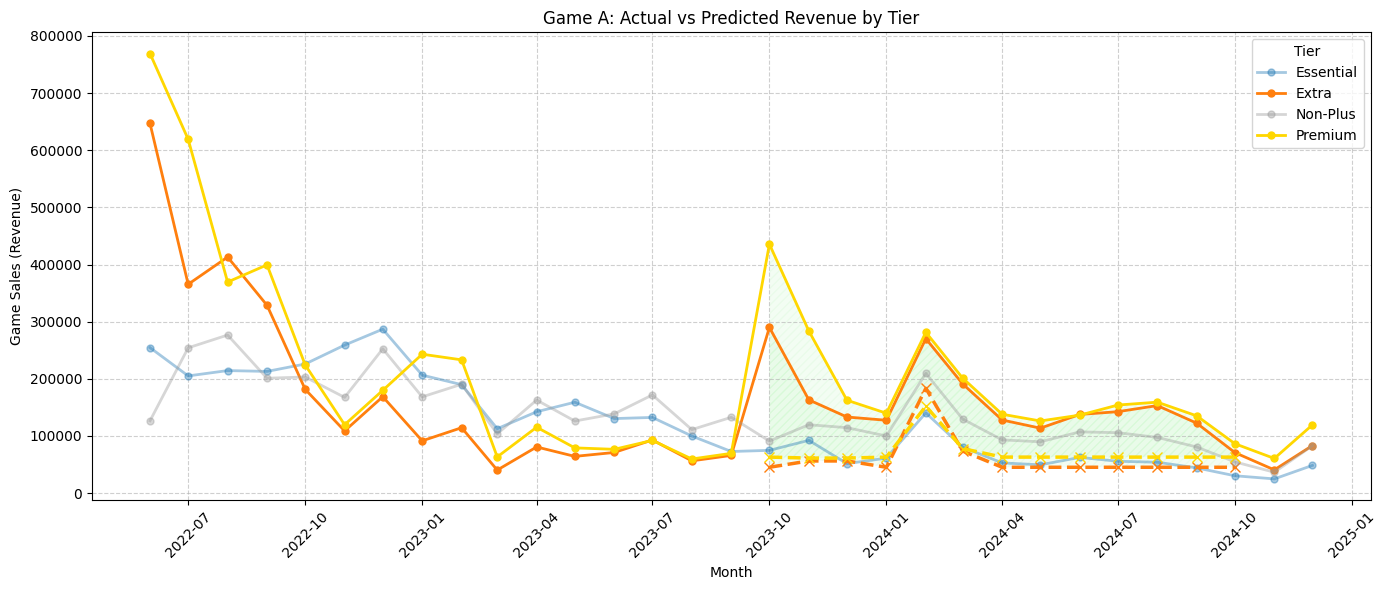

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Custom colors
tier_colors = {
    'Premium': '#FFD700',    # yellow
    'Extra': '#FF7F0E',      # orange
    'Essential': '#1f77b4',  # blue
    'Non-Plus': '#999999'    # gray
}

# === Ensure numeric inputs
merged_plot_data['Actual'] = pd.to_numeric(merged_plot_data['Actual'], errors='coerce')
merged_plot_data['Predicted'] = pd.to_numeric(merged_plot_data['Predicted'], errors='coerce')

# === Plot
plt.figure(figsize=(14, 6))
for tier in merged_plot_data['Tier'].unique():
    data = merged_plot_data[merged_plot_data['Tier'] == tier].copy()
    color = tier_colors.get(tier, 'black')
    is_control = tier in ['Essential', 'Non-Plus']

    # Actual line
    plt.plot(
        data['Month'], data['Actual'],
        marker='o', markersize=5, linewidth=2,
        color=color, alpha=0.4 if is_control else 1.0,
        label=tier
    )

    # Prediction line
    if data['Predicted'].notna().any():
        plt.plot(
            data['Month'], data['Predicted'],
            linestyle='--', linewidth=2.5, marker='x', markersize=7,
            color=color
        )

        # Softer light green overlay
        plt.fill_between(
            data['Month'],
            data['Actual'],
            data['Predicted'],
            where=(data['Actual'].notna() & data['Predicted'].notna()),
            interpolate=True,
            facecolor='lightgreen',
            alpha=0.1,
            hatch='////',
            edgecolor='lightgreen',
            linewidth=0
        )

plt.title('Game A: Actual vs Predicted Revenue by Tier')
plt.xlabel('Month')
plt.ylabel('Game Sales (Revenue)')
plt.xticks(rotation=45)
plt.legend(title='Tier')
plt.grid(True, linestyle='--', alpha=0.6)

# Transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)

plt.tight_layout()
plt.show()


In [ ]:
# === Step 1: Filter and pivot Game B again
game_b_df = df[df['Game'] == 'Game B'].copy()

pivot_b = game_b_df.pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Game Sales (Revenue)',
    aggfunc='sum'
).reset_index().dropna(subset=['Premium', 'Extra', 'Essential', 'Non-Plus'])

# === Step 2: Prepare modeling input
impact_df_premium_b = pivot_b[['Month', 'Premium', 'Essential', 'Non-Plus']].copy()
impact_df_premium_b.columns = ['Month', 'target', 'x1', 'x2']
impact_df_premium_b.set_index('Month', inplace=True)
impact_df_premium_b = impact_df_premium_b.astype(float)

impact_df_extra_b = pivot_b[['Month', 'Extra', 'Essential', 'Non-Plus']].copy()
impact_df_extra_b.columns = ['Month', 'target', 'x1', 'x2']
impact_df_extra_b.set_index('Month', inplace=True)
impact_df_extra_b = impact_df_extra_b.astype(float)

# === Step 3: Set intervention window for Game B
pre_cutoff = "2024-02-29"
prediction_start = "2024-03-01"
prediction_end = df['Month'].max().strftime('%Y-%m-%d')

# === Step 4: Re-run Game B models using existing function
premium_xgb_results_b, premium_model_b = train_and_predict_xgb_limited(impact_df_premium_b, 'Premium')
extra_xgb_results_b, extra_model_b = train_and_predict_xgb_limited(impact_df_extra_b, 'Extra')

xgb_combined_results_b = pd.concat([premium_xgb_results_b, extra_xgb_results_b], ignore_index=True)

# === Step 5: Build merged_plot_data for Game B
actuals_b = df[df['Game'] == 'Game B'].pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Game Sales (Revenue)',
    aggfunc='sum'
).reset_index()

merged_plot_data = actuals_b.melt(id_vars='Month', var_name='Tier', value_name='Actual')

# Merge predicted values into actuals
predicted_combined_b = pd.concat([premium_xgb_results_b, extra_xgb_results_b], ignore_index=True)

merged_plot_data = pd.merge(
    merged_plot_data,
    predicted_combined_b,
    on=['Month', 'Tier'],
    how='left',
    suffixes=('', '_pred')
)


In [ ]:
uplift = (predicted_combined_b
          .assign(Uplift=lambda d: d['Actual'] - d['Predicted'])
          .groupby('Tier')['Uplift']
          .sum())

# Format with commas
uplift_formatted = uplift.apply(lambda x: f"{x:,.0f}")
print(uplift_formatted)


Tier
Extra      -876,332
Premium    -398,139
Name: Uplift, dtype: object


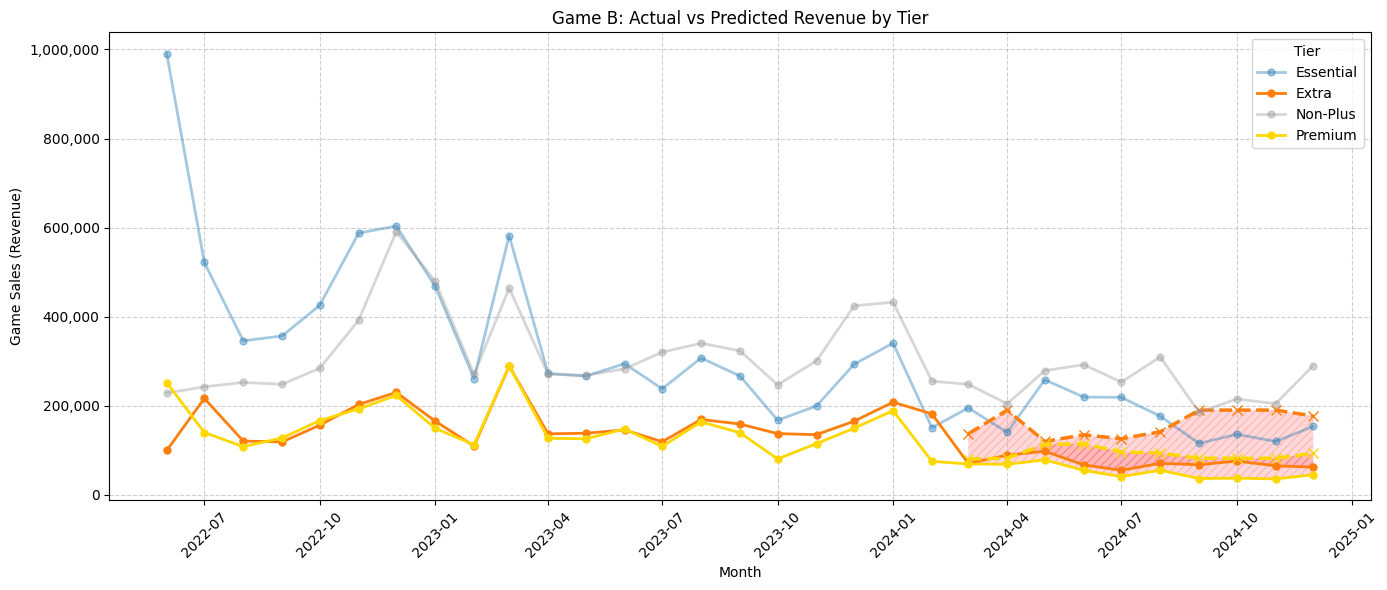

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Custom colors
tier_colors = {
    'Premium': '#FFD700',    # yellow
    'Extra': '#FF7F0E',      # orange
    'Essential': '#1f77b4',  # blue
    'Non-Plus': '#999999'    # gray
}

# === Ensure numeric inputs for safety
merged_plot_data['Actual'] = pd.to_numeric(merged_plot_data['Actual'], errors='coerce')
merged_plot_data['Predicted'] = pd.to_numeric(merged_plot_data['Predicted'], errors='coerce')

# === Plot
plt.figure(figsize=(14, 6))
for tier in merged_plot_data['Tier'].unique():
    data = merged_plot_data[merged_plot_data['Tier'] == tier].copy()
    color = tier_colors.get(tier, 'black')
    is_control = tier in ['Essential', 'Non-Plus']

    # Actual line
    plt.plot(
        data['Month'],
        data['Actual'],
        marker='o',
        markersize=5,
        linewidth=2,
        color=color,
        alpha=0.4 if is_control else 1.0,
        label=tier
    )

    # Predicted line
    if data['Predicted'].notna().any():
        plt.plot(
            data['Month'],
            data['Predicted'],
            linestyle='--',
            linewidth=2.5,
            marker='x',
            markersize=7,
            color=color
        )

        # Red overlay regardless of direction
        mask = data['Actual'].notna() & data['Predicted'].notna()
        x = data.loc[mask, 'Month'].values
        y1 = data.loc[mask, 'Actual'].astype(float).values
        y2 = data.loc[mask, 'Predicted'].astype(float).values

        if len(x) > 0 and len(y1) == len(y2):
            plt.fill_between(
                x, y1, y2,
                interpolate=True,
                facecolor='red',
                alpha=0.15,
                hatch='////',
                edgecolor='red',
                linewidth=0,
                label=None
            )

plt.title('Game B: Actual vs Predicted Revenue by Tier')
plt.xlabel('Month')
plt.ylabel('Game Sales (Revenue)')
plt.xticks(rotation=45)
plt.legend(title='Tier')
plt.grid(True, linestyle='--', alpha=0.6)

# Transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
plt.ticklabel_format(style='plain', axis='y')  # force non-scientific
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()


In [ ]:
# === Step 1: Filter and pivot Game B again but now for MTX
game_b_df = df[df['Game'] == 'Game B'].copy()

pivot_b = game_b_df.pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Av. MTX Spend',
    aggfunc='sum'
).reset_index().dropna(subset=['Premium', 'Extra', 'Essential', 'Non-Plus'])

# === Step 2: Prepare modeling input
impact_df_premium_b = pivot_b[['Month', 'Premium', 'Essential', 'Non-Plus']].copy()
impact_df_premium_b.columns = ['Month', 'target', 'x1', 'x2']
impact_df_premium_b.set_index('Month', inplace=True)
impact_df_premium_b = impact_df_premium_b.astype(float)

impact_df_extra_b = pivot_b[['Month', 'Extra', 'Essential', 'Non-Plus']].copy()
impact_df_extra_b.columns = ['Month', 'target', 'x1', 'x2']
impact_df_extra_b.set_index('Month', inplace=True)
impact_df_extra_b = impact_df_extra_b.astype(float)

# === Step 3: Set intervention window for Game B
pre_cutoff = "2024-02-29"
prediction_start = "2024-03-01"
prediction_end = df['Month'].max().strftime('%Y-%m-%d')

# === Step 4: Re-run Game B models using existing function
premium_xgb_results_b, premium_model_b = train_and_predict_xgb_limited(impact_df_premium_b, 'Premium')
extra_xgb_results_b, extra_model_b = train_and_predict_xgb_limited(impact_df_extra_b, 'Extra')

xgb_combined_results_b = pd.concat([premium_xgb_results_b, extra_xgb_results_b], ignore_index=True)

# === Step 5: Build merged_plot_data for Game B
actuals_b = df[df['Game'] == 'Game B'].pivot_table(
    index='Month',
    columns='Subscriber Tier',
    values='Av. MTX Spend',
    aggfunc='sum'
).reset_index()

merged_plot_data = actuals_b.melt(id_vars='Month', var_name='Tier', value_name='Actual')

# Merge predicted values into actuals
predicted_combined_b = pd.concat([premium_xgb_results_b, extra_xgb_results_b], ignore_index=True)

merged_plot_data = pd.merge(
    merged_plot_data,
    predicted_combined_b,
    on=['Month', 'Tier'],
    how='left',
    suffixes=('', '_pred')
)


In [ ]:
predicted_combined_b

,Month,Actual,Predicted,Tier
0,2024-03-01,1.251902,0.822347,Premium
1,2024-04-01,1.046324,0.802869,Premium
2,2024-05-01,0.956834,0.802869,Premium
3,2024-06-01,1.118417,0.802869,Premium
4,2024-07-01,1.029023,0.802869,Premium
5,2024-08-01,0.966117,0.842032,Premium
6,2024-09-01,1.156790,0.802869,Premium
7,2024-10-01,0.996770,0.802869,Premium
8,2024-11-01,0.997171,0.802869,Premium
9,2024-12-01,0.852056,0.802869,Premium


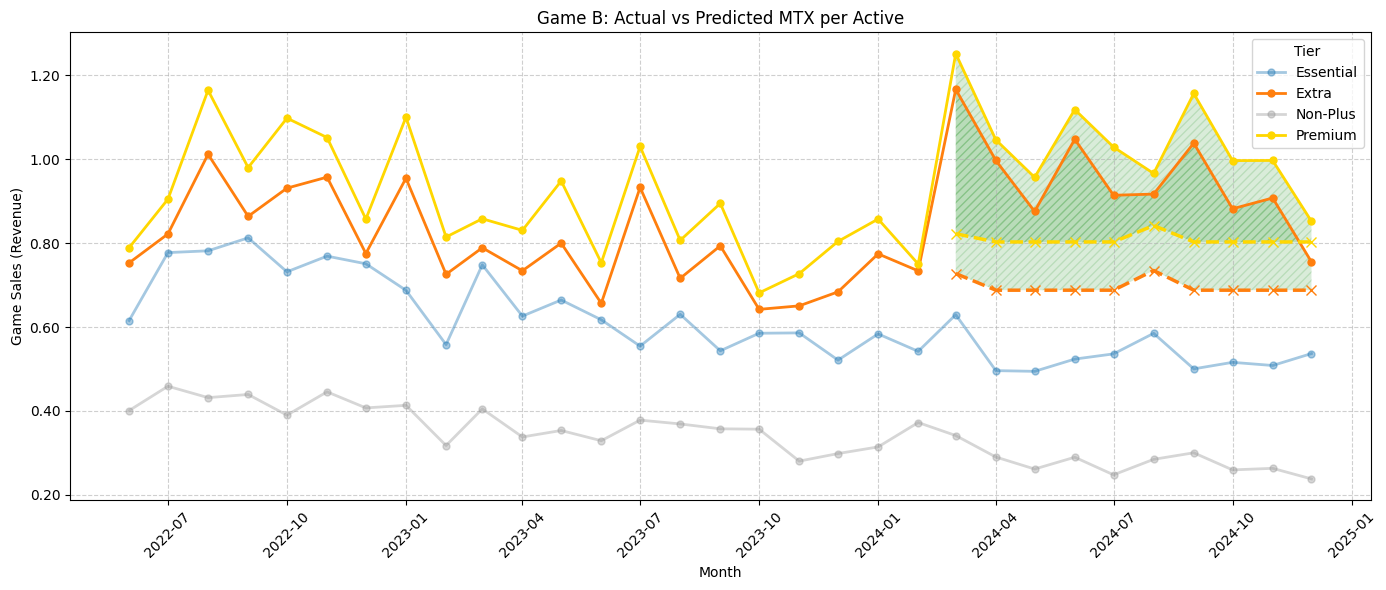

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Custom colors
tier_colors = {
    'Premium': '#FFD700',    # yellow
    'Extra': '#FF7F0E',      # orange
    'Essential': '#1f77b4',  # blue
    'Non-Plus': '#999999'    # gray
}

# === Ensure numeric inputs for safety
merged_plot_data['Actual'] = pd.to_numeric(merged_plot_data['Actual'], errors='coerce')
merged_plot_data['Predicted'] = pd.to_numeric(merged_plot_data['Predicted'], errors='coerce')

# === Plot
plt.figure(figsize=(14, 6))
for tier in merged_plot_data['Tier'].unique():
    data = merged_plot_data[merged_plot_data['Tier'] == tier].copy()
    color = tier_colors.get(tier, 'black')
    is_control = tier in ['Essential', 'Non-Plus']

    # Actual line
    plt.plot(
        data['Month'],
        data['Actual'],
        marker='o',
        markersize=5,
        linewidth=2,
        color=color,
        alpha=0.4 if is_control else 1.0,
        label=tier
    )

    # Predicted line
    if data['Predicted'].notna().any():
        plt.plot(
            data['Month'],
            data['Predicted'],
            linestyle='--',
            linewidth=2.5,
            marker='x',
            markersize=7,
            color=color
        )

        # Red overlay regardless of direction
        mask = data['Actual'].notna() & data['Predicted'].notna()
        x = data.loc[mask, 'Month'].values
        y1 = data.loc[mask, 'Actual'].astype(float).values
        y2 = data.loc[mask, 'Predicted'].astype(float).values

        if len(x) > 0 and len(y1) == len(y2):
            plt.fill_between(
                x, y1, y2,
                interpolate=True,
                facecolor='green',
                alpha=0.15,
                hatch='////',
                edgecolor='green',
                linewidth=0,
                label=None
            )

plt.title('Game B: Actual vs Predicted MTX per Active')
plt.xlabel('Month')
plt.ylabel('Game Sales (Revenue)')
plt.xticks(rotation=45)
plt.legend(title='Tier')
plt.grid(True, linestyle='--', alpha=0.6)

# Transparent background
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
plt.ticklabel_format(style='plain', axis='y')  # force non-scientific
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:,.2f}')
)

plt.tight_layout()
plt.show()


In [ ]:
merged_plot_data

,Month,Tier,Actual,Actual_pred,Predicted
0,2022-06-01,Essential,0.615600,NaN,NaN
1,2022-07-01,Essential,0.777457,NaN,NaN
2,2022-08-01,Essential,0.781779,NaN,NaN
3,2022-09-01,Essential,0.812615,NaN,NaN
4,2022-10-01,Essential,0.731685,NaN,NaN
...,...,...,...,...,...
119,2024-08-01,Premium,0.966117,0.966117,0.842032
120,2024-09-01,Premium,1.156790,1.156790,0.802869
121,2024-10-01,Premium,0.996770,0.996770,0.802869
122,2024-11-01,Premium,0.997171,0.997171,0.802869
